<a href="https://colab.research.google.com/github/IorioDiego/SOA-HPC/blob/master/HPC/Cuaderno_1_Miercoles__grupo11_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introducción**

El objetivo de este ejercicio es aplicarle a una imagen un filtro por medio de lenguaje Python.

Este filtro se llama Darkening Filter, consiste en oscurecer la imagen de acuerdo a un determinado porcentaje.

En ciertos casos, cuando la luz de la imagen es demasiada, la imagen parece ser mas clara de lo esperado. Darkening Filter puede ser usado para reducir el efecto de la luz reduciendo la intensidad de los pixeles de la imagen.

Se utiliza esta formula: 

G(x, y) = f(x, y) * b; 

Donde:
f: Imagen que se filtrara
G: Imagen filtrada
x: Coordenada X de un pixel de la imagen
y: Coordenada X de un pixel de la imagen
b: Debe valer entre 0 y 1, y es constante para todos los pixeles

El objetivo es enseñar el funcionamiento del Lenguaje Python y el manejo de Google Colab.

**Armado del ambiente**

En esta sección deben estar todos los comandos 
previos, que son necesarios para la ejecución del ejercicio. 

In [ ]:
#@title ## Parámetros de ejecución
#Se instala la biblioteca necesaria para trabajar con CUDA

!pip install pycuda

#Se obtiene la imagen de una URL
#@markdown ---

#@markdown ### Especifique la URL de la imagen al la que desea aplicar el filtro:
url_imagen = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Sudoku-by-L2G-20050714.svg/1200px-Sudoku-by-L2G-20050714.svg.png" #@param {type:"string"}

!wget {url_imagen} -O imagen.jpg

#Se define el valor para b que se utilizara en la ejecucion
#@markdown ### Especifique el valor del  filtro a aplicar:
b = 1 #@param {type:"slider", min:0, max:1, step:0.05}

--2021-11-19 02:05:45--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Sudoku-by-L2G-20050714.svg/1200px-Sudoku-by-L2G-20050714.svg.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64946 (63K) [image/png]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]  63.42K  --.-KB/s    in 0.06s   

2021-11-19 02:05:46 (1001 KB/s) - ‘imagen.jpg’ saved [64946/64946]



**Desarrollo CPU**

Debe tener el código que resuelve el ejercicio desde el punto 
de vista secuencial.

**Desarrollo GPU**

Debe tener el código que resuelve el ejercicio desde el punto 
de vista optimizado con CUDA.




Imagen del filtro: imagen.jpg -RGB- [768, 1024]
Thread: [ 16 , 19  ], Bloque : [ 48 , 54 ]
Total de Thread: [ 768 , 1026  ]  =  787968
Tiempo TOTAL:  68.749 [ms]
Tiempo GPU  :  0.167 [ms]


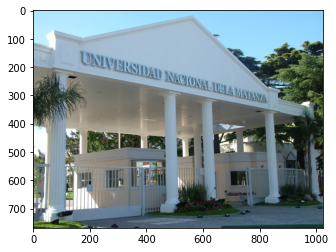

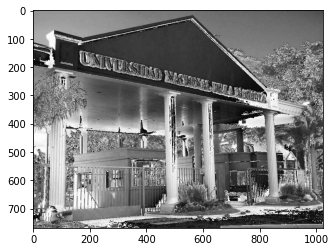

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

# Se abre la imagen para poder trabajar con ella
img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Se obtienen las proporciones de la imagen.
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like(img_O_cpu)

# Se reservan dos vectores en GPU
#En ambos vectores se poseen 3 pixeles usa RGB * el tamaño del array
img_O_gpu = cuda.mem_alloc(img_O_cpu.nbytes)
img_R_gpu = cuda.mem_alloc(img_R_cpu.nbytes)

# GPU - Se copia la memoria al GPU.
cuda.memcpy_htod(img_O_gpu, img_O_cpu )
cuda.memcpy_htod(img_R_gpu, img_R_cpu )

# CPU - Se define la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R, float b)
{
  // Se calculan las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  
  float nuevoValor;

  // Se verifica que los Thread, esten dentro de las dimensiones de la imagen.
  if(idx < ancho && idy < alto )
  {
     // Calculo los nuevos valores de los componentes R,G y B para el pixel a partir de los componentes originales.

     // Componente Rojo del pixel.
     nuevoValor = (float)img_O[(idx+(idy*ancho))*3]*b;

     // Componente Verde del pixel.
     nuevoValor +=(float)img_O[((idx+(idy*ancho))*3)+1]*b;

     // Componente Azul del pixel.
     nuevoValor +=(float)img_O[((idx+(idy*ancho))*3)+2]*b;  

     // Se escribe el color del pixel.
     img_R[(idx+(idy*ancho))*3  ] = (int) nuevoValor;
     img_R[(idx+(idy*ancho))*3+1] = (int) nuevoValor;
     img_R[(idx+(idy*ancho))*3+2] = (int) nuevoValor;
  }
}""")

# Se muestran los atributos de la imagen.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Se genera la función kernel.

kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel(numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, numpy.float32(b), block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1))

tiempo_img = datetime.now() - tiempo_img

# GPU - Se copia el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Se muestra la imagen original sin el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Se muestra la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

Imagen del filtro: imagen.jpg -RGB- [1200, 1200]


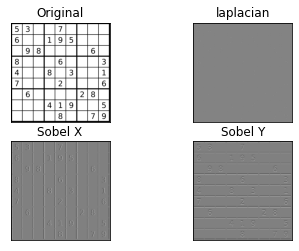

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
from datetime import datetime

#tiempo_total = datetime.now()

#import  matplotlib.pyplot as plt
import cv2
import numpy
from matplotlib import  pyplot as plt
from PIL import Image

# Definición de función que transforma el tiempo en milisegundos 
#tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

# Se abre la imagen para poder trabajar con ella
img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Se obtienen las proporciones de la imagen. 
img_alto, img_ancho = image.size 

# Se convierte la imagen JPEG o PNG a array.
img_pic_cpu = numpy.asarray(image)

# Se genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Se muestran los atributos de la imagen.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

#tiempo_img = datetime.now()

# Se aplica el filtro a la imagen en modo secuencial (CPU)
# Se obtienen los canales RGB de cada pixel, que representan a los colores Rojo (R), Verde (G), Azul (B). 

imgg = cv2.imread( 'imagen.jpg' , 0 )
laplacian = cv2.Laplacian(imgg,cv2.CV_64F)
sobelx = cv2.Sobel(imgg,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(imgg,cv2.CV_64F,0,1,ksize=3)

plt.subplot(2,2,1),plt.imshow(imgg,cmap= 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap= 'gray')
plt.title('laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap= 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap= 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

# Se muestra la imagen luego de aplicarle el filtro.
plt.figure()

plt.show()
#imgplot = plt.imshow( img_picR_cpu )

#tiempo_total = datetime.now() - tiempo_total

#print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
#print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

**Métricas**

Se recompilará la información obtenida de la ejecución secuencial y 
paralela.

b = 0

Tiempo Ejecucion Secuencial: 10418.453 [ms]

Tiempo Ejecucion Paralela: 2685.492 [ms]

b = 0.2

Tiempo Ejecucion Secuencial: 11162.119 [ms]

Tiempo Ejecucion Paralela: 3674.468 [ms]

b = 0.5

Tiempo Ejecucion Secuencial: 11406.54 [ms]

Tiempo Ejecucion Paralela: 2824.86 [ms]

b = 0.7

Tiempo Ejecucion Secuencial: 11234.276 [ms]

Tiempo Ejecucion Paralela: 3136.781 [ms]

b = 0.9

Tiempo Ejecucion Secuencial: 11654.53 [ms]

Tiempo Ejecucion Paralela: 2771.359 [ms]

b = 1

Tiempo Ejecucion Secuencial: 10430.351 [ms]

Tiempo Ejecucion Paralela: 2499.015 [ms]

**Conclusiones**

Explicación de las métricas obtenidas y sus comparaciones.

Para cada porcentaje de b se logra observar que la ejecucion secuencial, en la cual el CPU se encarga de realizar todo el procesamiento, es mas lenta que la ejecución en paralelo, en la cual se designa el procesamiento a hilos que se ejecutaran en paralelo, haciendo la ejecucion mas rapida.

**Bibliografía**

1.	Implementation of Image Enhancement Algorithms and Recursive Ray Tracing using CUDA. Mr. Diptarup Saha , Mr. Karan Darji , Dr. Narendra Patel , Dr. Darshak Thakore. 7th International Conference on Communication, Computing and Virtualization 2016

2. Ejemplo Prueba 2 - Imagen - CPU: [Página web](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20CPU.ipynb)

3. Ejemplo Prueba 3 - Imagen - GPU: [Página web](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb)

4. Explicación y ejemplos Python: [Página web](https://docs.python.org/es/3/contents.html)



---
# 1 Introducción
Sobel Filter



---
# 2 Armado del ambiente
Toma la direcciòn web de una imagen con acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

In [48]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://justin-liang.com/tutorials/canny/images/3_gaussian.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg



--2021-11-22 03:26:47--  https://justin-liang.com/tutorials/canny/images/3_gaussian.jpg?raw=true
Resolving justin-liang.com (justin-liang.com)... 204.44.192.35
Connecting to justin-liang.com (justin-liang.com)|204.44.192.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22970 (22K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]  22.43K  --.-KB/s    in 0.07s   

2021-11-22 03:26:47 (344 KB/s) - ‘imagen.jpg’ saved [22970/22970]



---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [1]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 66 kB 4.6 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627871 sha256=181f6b84fa5ec97906e63a26271a3cd4493957388041f1f71aec886c3cd9ba5b
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=09b91dfdd9f6e9a3266d2063a6a61cf6870c2d6cb353fc01f94c354b814d7348
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


---
# 3 Desarrollo
Ejecución del algoritmo escala de grises en GPU.

Imagen del filtro: imagen.jpg -L- [480, 480]
Thread: [ 16 , 19  ], Bloque : [ 30 , 26 ]
Total de Thread: [ 480 , 494  ]  =  237120
Tiempo TOTAL:  67.017 [ms]
Tiempo GPU  :  0.19 [ms]


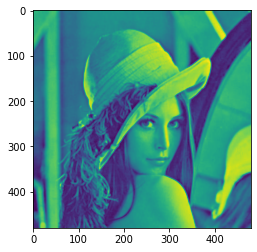

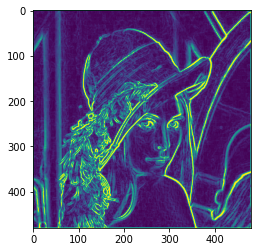

In [68]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu =  cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu =cuda.mem_alloc( img_R_cpu.nbytes )


# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int  *img_R )
{

   
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  int col = blockIdx .x * blockDim .x + threadIdx .x;
 int row = blockIdx .y * blockDim .y + threadIdx .y;

              if( col < ancho && row < alto ){
          int Gx [3][3] = { -1 , 0 , 1 ,
          -2 , 0 , 2 ,
          -1 , 0 , 1};

          int Gy [3][3] = {1 ,2 ,1 ,
          0 ,0 ,0 ,
          -1 , -2 , -1};

          int sumX , sumY ;
          sumX = sumY = 0;

          for (int i= -1; i <= 1; i++) {
          for (int j= -1; j <=1; j++) {
            
          

          int curPixel = img_O [( row + j) * ancho + (col + i) ];
          sumX += curPixel * Gx[i +1][ j +1];
          sumY += curPixel * Gy[i +1][ j +1];
        }
 }

 int sum = abs( sumY ) + abs( sumX ) ;
    if (sum > 255) sum = 255;
     if (sum < 0) sum = 0;
 img_R [row * ancho + col ] = sum ;

    }



  }

  




""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

#CPU

Imagen del filtro: imagen.jpg -L- [480, 480]
Tiempo de conversión de imagen: 5240.899 [ms]
Tiempo Total: 5278.077 [ms]


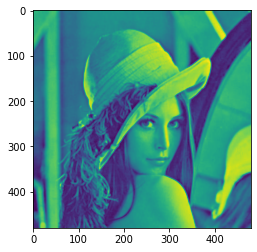

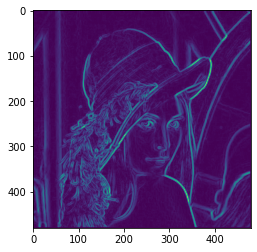

In [49]:
 %matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 

  
# Optengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img = datetime.now()

# Convierto la imagen a escala de grises

# sobel_x = [ [ -1, 0, 1 ],
#       [ -2, 0, 2 ],
#       [ -1, 0, 1 ] ];

# sobel_y = [ [ -1, -2, -1 ],
#       [ 0,  0,  0 ],
#       [  1,  2,  1 ] ];


# for a  in range(0, 3 ):
#       for b  in range( 0, 3 ):
#         xn = x + a - 1;
#         yn = y + b - 1;

#         index = xn + yn * img_ancho;
#       magX += img_pic_cpu[index] * sobel_x[a][b];

sobelx = numpy.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = numpy.float)
sobely = numpy.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = numpy.float)

N = img_alto
M = img_ancho


row = img_alto
column = img_ancho
sobelxImage = numpy.zeros((row,column))
sobelyImage = numpy.zeros((row,column))
sobelGrad = numpy.zeros((row,column))

#Start time





image = numpy.pad(image, (1,1), 'edge')

for i in range(1, N-1):
    for j in range(1, M-1):        
        #Calculate gx and gy using Sobel (horizontal and vertical gradients)
        gx = (sobelx[0][0] * image[i-1][j-1]) + (sobelx[0][1] * image[i-1][j]) + \
             (sobelx[0][2] * image[i-1][j+1]) + (sobelx[1][0] * image[i][j-1]) + \
             (sobelx[1][1] * image[i][j]) + (sobelx[1][2] * image[i][j+1]) + \
             (sobelx[2][0] * image[i+1][j-1]) + (sobelx[2][1] * image[i+1][j]) + \
             (sobelx[2][2] * image[i+1][j+1])

        gy = (sobely[0][0] * image[i-1][j-1]) + (sobely[0][1] * image[i-1][j]) + \
             (sobely[0][2] * image[i-1][j+1]) + (sobely[1][0] * image[i][j-1]) + \
             (sobely[1][1] * image[i][j]) + (sobely[1][2] * image[i][j+1]) + \
             (sobely[2][0] * image[i+1][j-1]) + (sobely[2][1] * image[i+1][j]) + \
             (sobely[2][2] * image[i+1][j+1])     

    

        #Calculate the gradient magnitude
        g =numpy.sqrt(gx * gx + gy * gy)
        sobelGrad[i-1][j-1] = g


# xKernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
# yKernel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
#     sobelled = numpy.zeros((img_ancho-2,img_alto[1]-2, 3), dtype="uint8")
#     for y in range(1, img_ancho-1):
#         for x in range(1, img_alto-1):
#             gx = numpy.sum(numpy.multiply(img[y-1:y+2, x-1:x+2], xKernel))
#             gy = numpy.sum(numpy.multiply(img[y-1:y+2, x-1:x+2], yKernel))
#             g = abs(gx) + abs(gy) #math.sqrt(gx ** 2 + gy ** 2) (Slower)
#             g = g if g > 0 and g < 255 else (0 if g < 0 else 255)
#             sobelled[y-1][x-2] = g




tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( sobelGrad )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )